# Audio Sentiment Classification from Short Utterances with MFCC and LSTM.
**Research Portfolio, Rifky Setiawan, Universitas Gadjah Mada (UGM)**

This notebook documents an end to end prototype for automatic sentiment recognition from short spoken utterances. The pipeline applies uniform preprocessing and deterministic MFCC construction, then trains a lightweight stacked LSTM on fixed shape sequences. Evaluation emphasizes accuracy, macro F1, and confusion analysis to surface systematic errors under class imbalance.

The objective is to demonstrate practical ability to design and implement a speech analysis pipeline that is clear, reproducible, and compute friendly. The artifact is intended for triage and academic study, not for automated policy or legal decisions. This notebook is submitted as part of a research internship application.


## Abstract

This notebook investigates audio sentiment classification from short spoken utterances where prosodic cues carry information that text alone may miss. The goal is a dependable baseline that remains compute friendly and reproducible under acoustic variability and class imbalance. The approach uses deterministic MFCC features with fixed shapes and a lightweight stacked LSTM that models temporal structure over time. Evaluation emphasizes macro F1 and confusion analysis so that systematic errors between acoustically similar classes are visible alongside overall accuracy.

The workflow is organized for clarity from raw audio to evaluated predictions. It covers environment setup, TESS directory indexing with canonical labels, MFCC construction with padding or trimming and standardization, a train and validation split with a fixed seed, tensor reshaping for recurrent layers, training with early stopping and learning rate reduction, and reporting with a classification report and a confusion matrix. A compact inference demo applies the trained model to curated examples for qualitative inspection. The design favors simple components and fixed preprocessing so that results can be recreated on Google Colab or a comparable environment.

This work is intended for research and teaching. It highlights patterns for qualitative review and model iteration. It is not a policy or legal decision system and a human remains in the loop.

## 1. Problem Statement and Motivation

Audio sentiment analysis faces two simultaneous challenges:
- handling acoustic variability across speakers, microphones, and environments
- learning under class imbalance with short utterances that provide limited lexical evidence

Prosody carries cues that text may miss, yet short clips can blur boundaries between adjacent polarities. Mapping these signals to a fixed taxonomy such as Negative, Neutral, and Positive requires a pipeline that is consistent, compute friendly, and easy to audit.

This notebook investigates a compact recurrent formulation:
a deterministic MFCC front end produces fixed length sequences,
a lightweight stacked LSTM models temporal structure over time,
and evaluation emphasizes macro F1 with confusion analysis to surface systematic errors.

This approach:
- focuses on prosodic signal with low computational cost
- improves reproducibility through fixed preprocessing and shapes
- supports fair assessment under imbalance via macro F1 and per class metrics

The intended use is research and teaching. Predictions highlight patterns for qualitative review and model iteration. Outputs are not policy or legal determinations and a human remains in the loop.


## 2. Pipeline Overview

This pipeline is organized for clarity and reproducibility from raw audio to evaluated predictions. It reflects the TESS directory layout and the MFCC feature extractor used in this notebook.

1. **Setup and Imports**: numerical, audio, and deep-learning libraries, Google Drive mount, plotting configuration.
2. **Dataset Indexing and Labels**: resolve the TESS root, collect `.wav` files from `OAF_` and `YAF_` folders, normalize class names, encode labels.
3. **Preprocessing and Feature Extraction**: resample to a fixed rate, trim or pad duration, peak-normalize, compute MFCC with deterministic framing, optional lightweight augmentation.
4. **Model Architecture (RNN)**: stacked LSTM operating on time-major MFCC sequences with dropout and batch normalization.
5. **Training**: early stopping with best-weight restore and learning-rate reduction for stable convergence.
6. **Evaluation**: accuracy and macro F1, per-class classification report, confusion matrix for diagnostic inspection.
7. **Responsible Use and Limitations**: scope, dataset coverage, and the requirement for a human-in-the-loop.


## 3. Environment Setup and Dependencies

This cell prepares a clean runtime by installing the core packages used for audio loading, feature extraction, model training, and evaluation. It should be executed once in a fresh session to make sure versions are consistent across runs and to prevent silent mismatches between local and hosted environments. The installation targets audio utilities, deep-learning back ends, and standard data science tools so that the remainder of the notebook can focus on the research steps rather than system issues.

Keep in mind that installing inside a notebook can take several minutes on the first run, while subsequent executions are faster due to cached wheels.

Packages to confirm:
- `librosa` and `sounddevice` for audio I/O and basic signal utilities
- `tensorflow` for model definition and training
- `scikit-learn` and `numpy` for metrics and numerics


In [ ]:
# Install required libraries
!pip install librosa tensorflow scikit-learn
!pip install sounddevice numpy librosa tensorflow

### 3a. Optional Windows Audio Utilities

This cell installs convenience tools that simplify native audio I/O on Windows machines. It is primarily useful for local development where microphone capture or direct audio playback is required. On Google Colab the audio stack is different, so this step is usually not needed. Retaining the cell keeps the notebook portable for readers who may reproduce the results on a Windows laptop.

Small guidance for portability:
- Use `pipwin` to fetch prebuilt wheels that match the local Python runtime
- Use `pyaudio` only if plan to test live recording


In [ ]:
!pip install pipwin
!pipwin install pyaudio

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.2 MB/s eta 0:00:00
  Created wheel for pipwin: filename=pipwin-0.5.2-py2.py3-none-any.whl size=8770 sha256=80d11a1f27333de5ae8a0929e26fe50fcd28889968bde5ce43d0320f9ca8f093
  Stored in directory: /root/.cache/pip/wheels/e8/b5/1d/b94f69a230c016fe50ed36399dec48b34b82a11e4f344e9ccb
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3cff9042beb075b0757f87bfc041b27c806f94b668563f8186e88bc5bb11f96e
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25982 sha256=f935862782c8d7fe5c3a6a1c9de0f50496ffd638fa907bd4d83aa4c4c87d4767
  Stored in directory: /root/.cache/pip/wheels/14/32/1d/9ef7b582e358446aeef4b9052aa89ef4dffa1688c1aae8aa13
Successfully b

## 4. Setup and Imports

This section loads standard libraries, mounts Google Drive for dataset access, and configures plotting so figures remain clear in exported reports. The imports are grouped by function to keep the environment understandable for readers who will inspect or reuse this notebook. Warnings that are not actionable are muted to keep the output focused on the scientific results.

Scope covered in this cell:
- System paths and basic utilities for file handling
- Numerics and tabular data for analysis and logging
- Audio loading and visualization with `librosa` and `soundfile`
- Modeling and callbacks with TensorFlow Keras
- Evaluation utilities from scikit-learn and lightweight plotting


In [ ]:
# Setup and Imports

# Core
import os, warnings, time
from pathlib import Path
from collections import Counter

# Numerics & data
import numpy as np
import pandas as pd

# Audio I/O & features
import librosa, librosa.display
import soundfile as sf

# Modeling & evaluation (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

# Deep learning (TensorFlow / Keras)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Drive
from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 5. Dataset Location and Indexing

The goal of this cell is to resolve the TESS directory on Google Drive and to construct a reliable file index with normalized class labels. The code searches several candidate roots because personal Drive layouts often differ. Once the correct root is found, all `.wav` files are collected and their class names are derived from folder prefixes such as `OAF_` and `YAF_`. Labels are then encoded to integers to enable stable training and evaluation. Printing the class histogram serves as a quick validation that the dataset is complete and that no label was silently skipped.

Brief checklist:
- Locate a root that actually contains the expected class folders
- Build a table of absolute paths and canonical label tokens
- Create `ID2LABEL` and `LABEL2ID` mappings and verify per-class counts


In [ ]:
# Root folder on Google Drive (your structure)
DATA_ROOT = Path("/content/drive/MyDrive/Dataset/Dataset Emotional Speech")

# TESS sometimes lives inside a named subfolder; otherwise OAF_/YAF_ are directly under DATA_ROOT
CANDIDATES = [
    DATA_ROOT / "TESS Toronto emotional speech set data",
    DATA_ROOT / "TESS Toronto emotional speech set data (1)",
    DATA_ROOT,  # fallback: OAF_/YAF_ placed directly here
]

# Pick the first candidate that actually contains OAF_/YAF_ folders
def find_tess_root():
    for root in CANDIDATES:
        if root.exists():
            subdirs = [p for p in root.iterdir() if p.is_dir()]
            if any(d.name.startswith(("OAF_", "YAF_")) for d in subdirs):
                return root
    raise FileNotFoundError(
        "Could not find TESS class folders (OAF_/YAF_). "
        f"Tried: {', '.join(str(p) for p in CANDIDATES)}"
    )

TESS_ROOT = find_tess_root()
print("Using TESS root:", TESS_ROOT)

# Collect class folders (OAF_angry, YAF_happy, etc.)
class_dirs = sorted([p for p in TESS_ROOT.iterdir()
                     if p.is_dir() and p.name.startswith(("OAF_", "YAF_"))])
assert len(class_dirs) > 0, f"No class folders found under: {TESS_ROOT}"

# Normalize label names from folder names (tail after 'OAF_' or 'YAF_')
def normalize_label_from_dirname(dirname: str) -> str:
    # take tail after the first underscore, lowercase, unify synonyms
    tail = dirname.split("_", 1)[1] if "_" in dirname else dirname
    tail = tail.strip().lower().replace(" ", "_").replace("-", "_")
    # unify common variants
    if tail in {"pleasant_surprised", "pleasant_surprise"}:
        tail = "pleasant_surprise"
    if tail == "sadness":
        tail = "sad"
    return tail  # keep as lowercase token; you may title-case later if needed

rows = []
for d in class_dirs:
    label = normalize_label_from_dirname(d.name)
    wavs = sorted(d.rglob("*.wav"))
    for w in wavs:
        rows.append({"path": str(w), "label": label})

df = pd.DataFrame(rows)
assert len(df) > 0, f"No .wav files found under: {TESS_ROOT}"

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])
ID2LABEL = {int(i): lab for i, lab in enumerate(le.classes_)}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

print("Classes (normalized):", ID2LABEL)
print("Per-class counts:", dict(Counter(df["label"])))
print("Total files:", len(df))

# (Optional) For compatibility with existing code that expects this:
Main_WAV_Path = TESS_ROOT  # handle named like your old variable

Using TESS root: /content/drive/MyDrive/Dataset/Dataset Emotional Speech/TESS Toronto emotional speech set data
Classes (normalized): {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'pleasant_surprise', 6: 'sad'}
Per-class counts: {'fear': 400, 'pleasant_surprise': 400, 'sad': 400, 'angry': 400, 'disgust': 400, 'happy': 400, 'neutral': 400}
Total files: 2800


## 6. Deterministic MFCC Feature Extraction and Batch Assembly

This cell provides a safe fallback for `extract_mfcc` and builds features for the entire corpus. Each waveform is loaded at a fixed sample rate and peak normalized to avoid clipping. MFCC features are computed with deterministic framing so that repeated runs yield the same shapes. Time padding or trimming enforces a constant sequence length and per-coefficient standardization stabilizes optimization across speakers and recording channels. The features are stacked into a three dimensional tensor while labels are stored as integers that align with the previously created mapping.

Outputs recorded here:
- `X` shaped `[N, MAX_PAD, N_MFCC]` in time by feature format for direct use with recurrent layers
- `y` as integer class IDs that are consistent with `ID2LABEL`


In [ ]:
# Fallback: define extract_mfcc if the preprocessing cell was not executed
try:
    extract_mfcc  # noqa: F821
except NameError:
    import librosa
    SR, N_MFCC, MAX_PAD = 16000, 40, 500

    def load_wav(path: str, sr: int = SR):
        y, _ = librosa.load(path, sr=sr, mono=True)
        peak = np.max(np.abs(y)) + 1e-9
        return y / peak

    def extract_mfcc(path_or_wav, sr: int = SR, n_mfcc: int = N_MFCC, max_pad: int = MAX_PAD):
        if isinstance(path_or_wav, (str, os.PathLike)):
            y = load_wav(str(path_or_wav), sr=sr)
        else:
            y = np.asarray(path_or_wav, dtype=np.float32)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, center=False)
        T = mfcc.shape[1]
        if T < max_pad:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_pad - T)), mode="constant")
        elif T > max_pad:
            mfcc = mfcc[:, :max_pad]
        mu = mfcc.mean(axis=1, keepdims=True)
        sd = mfcc.std(axis=1, keepdims=True) + 1e-6
        mfcc = (mfcc - mu) / sd
        return mfcc.T  # (MAX_PAD, N_MFCC)

    print("[INFO] `extract_mfcc` not found; using local fallback.")

# Build features
X_list, y_list = [], []
n = len(df)
tick = max(1, n // 10)

for i, r in df.reset_index(drop=True).iterrows():
    feat = extract_mfcc(r["path"])
    X_list.append(feat)
    y_list.append(int(r["label_id"]))
    if (i + 1) % tick == 0 or (i + 1) == n:
        print(f"[{i+1}/{n}] features built")

X = np.stack(X_list).astype(np.float32)
y = np.asarray(y_list, dtype=np.int32)
print("X shape:", X.shape, "| y shape:", y.shape)

[INFO] `extract_mfcc` not found; using local fallback.
[280/2800] features built
[560/2800] features built
[840/2800] features built
[1120/2800] features built
[1400/2800] features built
[1680/2800] features built
[1960/2800] features built
[2240/2800] features built
[2520/2800] features built
[2800/2800] features built
X shape: (2800, 500, 40) | y shape: (2800,)


## 7. Loader with Lightweight Augmentation

This cell defines a loader that can rescan class folders, apply simple augmentations, and compute MFCC features in a consistent way. Augmentations are intentionally mild so that label semantics remain unchanged while the model sees small variations in noise, timing, and speaking rate. Shapes are kept identical across all samples in order to simplify batching and to avoid dynamic padding during training.

Augmentations included in the loader:
- Additive noise at a target signal-to-noise ratio to improve robustness
- Circular time shift to mimic alignment jitter
- Time stretch with length repair to simulate small rate changes

The function returns a feature tensor with uniform temporal length along with one-hot labels and a fitted `LabelEncoder`. In this notebook the main experiments proceed with features already computed in the previous step, while this loader remains available for end-to-end runs.


In [ ]:
# Data loader with MFCC features and on-the-fly augmentation (TESS: OAF_/YAF_ folders)

# Core audio/MFCC configuration (keep aligned with the rest of the notebook)
SR        = 16000   # fixed sample rate for all files
N_MFCC    = 40      # number of MFCC coefficients per frame
MAX_PAD   = 500     # fixed number of time frames after pad/truncate
TARGET_S  = 3       # target waveform duration in seconds for augmentation pipeline

def normalize_label(dirname: str) -> str:
    """
    Normalize TESS-style folder names to canonical class tokens.
    Examples:
      'OAF_angry' -> 'angry', 'YAF_pleasant_surprised' -> 'pleasant_surprise'
    """
    tail = dirname.split("_", 1)[1] if "_" in dirname else dirname
    t = tail.strip().lower().replace(" ", "_").replace("-", "_")
    if t in {"pleasant_surprised", "pleasant_surprise"}:
        t = "pleasant_surprise"
    if t == "sadness":
        t = "sad"
    return t

def extract_mfcc_features(y: np.ndarray, sr: int = SR, n_mfcc: int = N_MFCC, max_pad: int = MAX_PAD) -> np.ndarray:
    """
    Compute MFCCs (n_mfcc x T) from a waveform, then pad/trim the time axis
    to 'max_pad' and apply per-coefficient standardization.
    Returns shape: (max_pad, n_mfcc), time-major for RNNs.
    """
    # Deterministic framing (center=False) to avoid edge effects with short clips
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, center=False)
    T = mfcc.shape[1]

    # Pad/trim to a fixed temporal length so downstream models see a consistent shape
    if T < max_pad:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_pad - T)), mode="constant")
    elif T > max_pad:
        mfcc = mfcc[:, :max_pad]

    # Per-coefficient standardization stabilizes training across speakers/utterances
    mu = mfcc.mean(axis=1, keepdims=True)
    sd = mfcc.std(axis=1, keepdims=True) + 1e-6
    mfcc = (mfcc - mu) / sd

    # Transpose to (time, features) so it matches (MAX_PAD, N_MFCC)
    return mfcc.T

def add_noise(y: np.ndarray, snr_db: float = 15.0) -> np.ndarray:
    """
    Additive Gaussian noise at a target SNR (in dB). Helps robustness to channel noise.
    """
    rms = np.sqrt(np.mean(y**2) + 1e-9)
    noise_rms = rms / (10**(snr_db / 20))
    out = y + np.random.normal(0, noise_rms, size=y.shape)
    # Peak-normalize to avoid clipping
    return out / (np.max(np.abs(out)) + 1e-9)

def time_shift(y: np.ndarray, max_frac: float = 0.2) -> np.ndarray:
    """
    Circular time shift by up to ±max_frac of the signal length. Simulates alignment jitter.
    """
    max_shift = int(len(y) * max_frac)
    shift = np.random.randint(-max_shift, max_shift + 1)
    return np.roll(y, shift)

def time_stretch_safe(y: np.ndarray, rate: float = 1.1, target_len: int | None = None) -> np.ndarray:
    """
    Librosa time-stretch with version-safe call signature and length repair to 'target_len'.
    If stretching fails (rare environment-specific issues), returns the original waveform.
    """
    try:
        # librosa >= 0.10 supports keyword 'rate'; older versions allow positional
        y2 = librosa.effects.time_stretch(y=y, rate=rate)
    except TypeError:
        y2 = librosa.effects.time_stretch(y, rate)
    except Exception:
        y2 = y

    if target_len is None:
        target_len = len(y)

    # Pad/crop back to the target length for shape consistency
    if len(y2) < target_len:
        y2 = np.pad(y2, (0, target_len - len(y2)))
    else:
        y2 = y2[:target_len]
    return y2

def load_data(dataset_path: str, labels_mapping=None, augment: bool = False):
    """
    Scan a TESS-like directory of class subfolders (OAF_*, YAF_*). For each .wav file:
    - load at SR Hz, mono;
    - pad/crop to TARGET_S seconds for consistent augmentation behavior;
    - compute MFCC features (time x N_MFCC);
    - optionally add 3 augmented variants (noise, time shift, time stretch).

    Returns:
    - X: np.ndarray of shape (N, T, N_MFCC) with fixed T (after pad/trim),
    - Y: one-hot labels of shape (N, num_classes),
    - label_encoder: fitted LabelEncoder for mapping indices <-> class names.
    """
    features, labels = [], []
    target_len = int(SR * TARGET_S)

    # Walk class folders; only consider TESS-style names to avoid stray directories
    for entry in sorted(os.listdir(dataset_path)):
        dpath = os.path.join(dataset_path, entry)
        if not os.path.isdir(dpath) or not (entry.startswith("OAF_") or entry.startswith("YAF_")):
            continue

        label = normalize_label(entry)

        # Iterate WAV files inside each class folder
        for fn in sorted(os.listdir(dpath)):
            if not fn.lower().endswith(".wav"):
                continue
            fp = os.path.join(dpath, fn)

            # Load waveform, fix duration, and peak-normalize to stabilize features
            y, _ = librosa.load(fp, sr=SR, mono=True)
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)))
            else:
                y = y[:target_len]
            y = y / (np.max(np.abs(y)) + 1e-9)

            # Original sample
            features.append(extract_mfcc_features(y, sr=SR))
            labels.append(label)

            if augment:
                # Three lightweight augmentations that preserve label semantics
                y_n = add_noise(y)
                y_s = time_shift(y)
                y_t = time_stretch_safe(y, rate=np.random.uniform(0.9, 1.1), target_len=target_len)

                features.append(extract_mfcc_features(y_n, sr=SR)); labels.append(label)
                features.append(extract_mfcc_features(y_s, sr=SR)); labels.append(label)
                features.append(extract_mfcc_features(y_t, sr=SR)); labels.append(label)

    # Encode labels to contiguous integers [0..C-1] and then one-hot
    le = LabelEncoder()
    y_idx = le.fit_transform(labels)
    Y = to_categorical(y_idx, num_classes=len(le.classes_))

    # Pad each (T_i, N_MFCC) feature to the maximum T across samples; ensure consistent batch shape
    max_len = max(f.shape[0] for f in features)
    X = np.stack([
        np.pad(f, ((0, max_len - f.shape[0]), (0, 0)), mode="constant")
        for f in features
    ]).astype(np.float32)

    return X, Y, le

## 8. Train and Validation Split

A held-out validation subset is created to estimate generalization without touching the test protocol. The split uses a fixed random seed so comparisons between runs remain fair and so that changes in metrics reflect modeling choices rather than sampling noise. The standard eighty to twenty split balances the need for sufficient training signal with the need for a reliable validation readout.

Artifacts produced for later steps:
- `X_train`, `X_test`, `y_train`, `y_test` with reproducible partitions


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 9. LSTM Input Shape Preparation

Recurrent layers expect three dimensional tensors where the second dimension encodes time steps and the third dimension encodes feature coefficients. This cell reshapes the prepared arrays to match that contract so that downstream layers can process sequences directly. Keeping the format consistent also makes it easier to export the model later.

Target shape reminder:
- `samples, timesteps, features` equals `[N, MAX_PAD, N_MFCC]`


In [ ]:
# Reshape data for LSTM input (LSTM expects 3D input: samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## 10. RNN Model and Training Procedure

Here a stacked LSTM classifier is defined and trained with early stopping and adaptive learning rate. The code first detects whether the labels are one-hot or integer encoded and then selects the appropriate loss, which removes a common source of silent misconfiguration. The architecture consists of several recurrent layers with dropout and batch normalization to improve stability on relatively small datasets, followed by a dense softmax head sized by the number of classes. Training monitors the validation loss, restores the best weights, and reduces the learning rate when progress stalls. Printing the selected loss type and the number of classes provides a small audit trail for later reproduction.

Key elements to notice:
- Label format check with automatic loss selection
- Regularized LSTM stack followed by a compact softmax head
- Early stopping and reduce on plateau for stable convergence


In [ ]:
# Build & Train RNN (handles one-hot or integer labels)

# Detect label format
if getattr(y_train, "ndim", 1) == 2:
    NUM_CLASSES = y_train.shape[1]
    loss_fn = 'categorical_crossentropy'
    y_tr, y_va = y_train, y_test           # one-hot targets
else:
    NUM_CLASSES = int(np.max(y_train)) + 1
    loss_fn = 'sparse_categorical_crossentropy'
    y_tr, y_va = y_train, y_test           # integer targets

# RNN stack
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Early stopping for stability on small datasets
callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=5, min_delta=2e-3,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',
                      patience=2, factor=0.5, min_lr=1e-5, cooldown=1),
]

history = model.fit(
    X_train, y_tr,
    validation_data=(X_test, y_va),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print(f"Loss used: {loss_fn} | NUM_CLASSES: {NUM_CLASSES}")

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.7676 - loss: 0.6935 - val_accuracy: 0.6750 - val_loss: 0.9145 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 339s 9s/step - accuracy: 0.9766 - loss: 0.0925 - val_accuracy: 0.8036 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9848 - loss: 0.0596 - val_accuracy: 0.9161 - val_loss: 0.2967 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 287s 8s/step - accuracy: 0.9753 - loss: 0.0763 - val_accuracy: 0.9536 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.9816 - loss: 0.0723 - val_accuracy: 0.8768 - val_loss: 0.4323 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 301s 9s/step - accuracy: 0.9704 - loss: 0.0874 - val_accuracy: 0.8536 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 290s 8s/step - accuracy: 0.9845 - loss: 0.0545 - 

## 11. Evaluation on the Validation Split

This section measures generalization on data that the model did not see during training. Predictions are converted to class IDs, mapped back to human readable labels, and scored with standard metrics. Accuracy summarizes overall correctness, while macro F1 gives each class the same weight, which is important when class frequencies are not perfectly balanced. A confusion matrix is also plotted to reveal systematic confusions that often occur between classes with similar prosody. The combination of scalar metrics and the matrix view provides both a global and a diagnostic perspective.

Metrics and plots included:
- Accuracy and macro F1 with a full classification report
- Confusion matrix with readable tick labels for inspection


Accuracy (val): 0.9946
Macro-F1 (val): 0.9946

Per-class report:
                    precision    recall  f1-score   support

            angry       1.00      0.99      0.99        74
          disgust       1.00      1.00      1.00        69
             fear       0.99      1.00      0.99        74
            happy       0.99      0.99      0.99        87
          neutral       1.00      1.00      1.00        92
pleasant_surprise       0.99      0.99      0.99        79
              sad       1.00      1.00      1.00        85

         accuracy                           0.99       560
        macro avg       0.99      0.99      0.99       560
     weighted avg       0.99      0.99      0.99       560



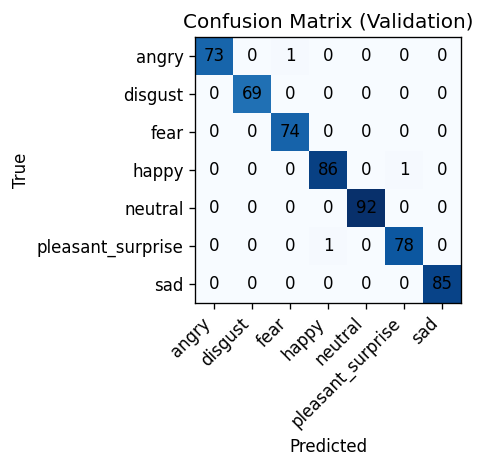

In [ ]:
# Evaluation

# Predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground-truth: handle one-hot vs integer labels
if getattr(y_test, "ndim", 1) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test.astype(int)

# Class names (fallback to numeric if mapping not available)
if 'ID2LABEL' in globals():
    class_names = [ID2LABEL[i] for i in range(y_pred.shape[1])]
else:
    n_classes = int(max(y_pred.shape[1], y_true.max()+1))
    class_names = [f"class_{i}" for i in range(n_classes)]

# Metrics
acc = accuracy_score(y_true, y_pred_classes)
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"Accuracy (val): {acc:.4f}")
print(f"Macro-F1 (val): {macro_f1:.4f}\n")

print("Per-class report:\n",
      classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=list(range(len(class_names))))
fig, ax = plt.subplots(figsize=(5,4))
ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion Matrix (Validation)')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout(); plt.show()

## 12. Metrics Summary

This compact summary contrasts macro and weighted averages so the reader can interpret performance under class imbalance. Macro averages treat all classes equally and therefore highlight minority errors, while weighted averages reflect the actual class support and can hide failures on rare categories. Reporting both helps maintain transparency when selecting models for follow-up experiments.

Interpretation tips:
- Prefer macro scores for fairness across classes
- Use weighted scores to estimate impact at observed frequencies


In [ ]:
# Metrics Summary

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# assumes y_true, y_pred_classes, class_names exist from the Evaluation cell
acc = accuracy_score(y_true, y_pred_classes)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_true, y_pred_classes, average='macro', zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred_classes, average='weighted', zero_division=0
)

print(f"Accuracy        : {acc:.4f}")
print(f"Macro   - P/R/F1: {prec_m:.4f} / {rec_m:.4f} / {f1_m:.4f}")
print(f"Weighted- P/R/F1: {prec_w:.4f} / {rec_w:.4f} / {f1_w:.4f}")

Accuracy        : 0.9946
Macro   - P/R/F1: 0.9946 / 0.9946 / 0.9946
Weighted- P/R/F1: 0.9947 / 0.9946 / 0.9946


## 13. Learning Curves

The learning curves show how accuracy and loss evolve across epochs and help diagnose the fit regime. A rising training curve with a flat validation curve may indicate overfit, while both curves that remain low may indicate underfit or suboptimal optimization. The cell also prints the best and the average validation accuracy to make it easy to compare runs without rereading the plots.

What to check quickly:
- Best and average validation accuracy trends
- Divergence between train and validation curves as a signal of overfit


Best Val Accuracy: 0.9946 | Avg Val Accuracy: 0.9293


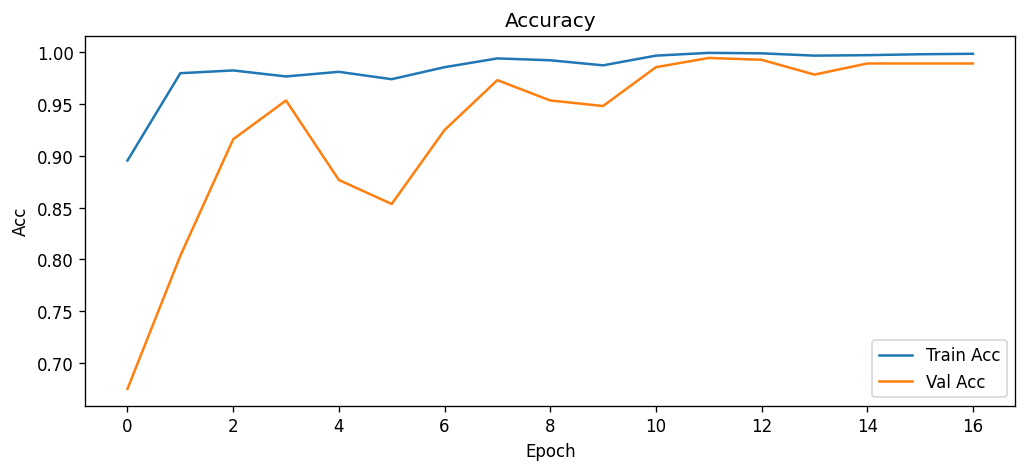

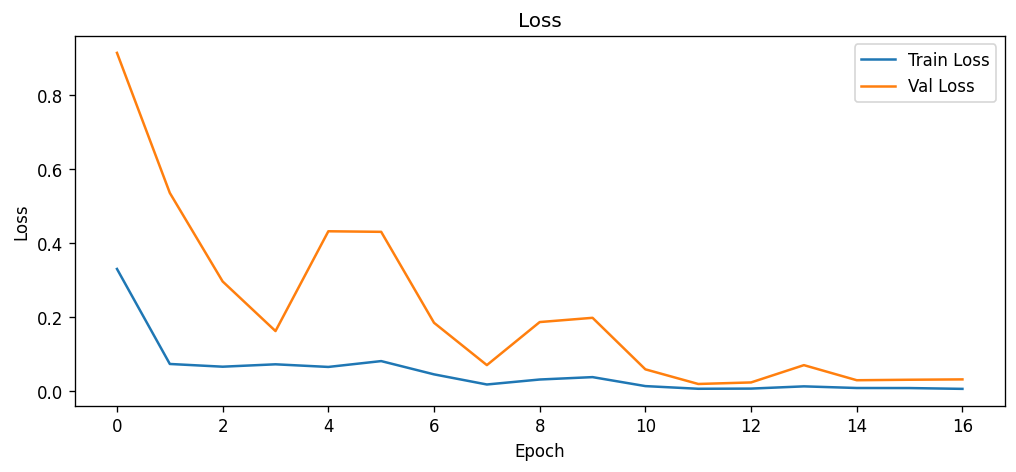

In [ ]:
# Training Curves

import numpy as np
import matplotlib.pyplot as plt

# assumes 'history' is available
val_acc = history.history.get('val_accuracy', [])
val_loss = history.history.get('val_loss', [])
best_val_acc = float(np.max(val_acc)) if len(val_acc) else float('nan')
avg_val_acc  = float(np.mean(val_acc)) if len(val_acc) else float('nan')
print(f"Best Val Accuracy: {best_val_acc:.4f} | Avg Val Accuracy: {avg_val_acc:.4f}")

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

## 14. Inference Demo

This qualitative demo runs the trained model on a small set of curated audio files. Each file is converted to MFCC using the same configuration as training, passed through the model to obtain softmax probabilities, and reported with a top label and a confidence value. The example list aims to be class balanced, but the cell also filters out missing files so the demo does not fail on a new environment. The printed results are concise enough for quick inspection and are useful when sharing the notebook as a research portfolio artifact.

Practical notes:
- Use exactly the same feature extraction for training and inference
- Keep the file list synchronized with the current dataset root and avoid I/O errors


In [ ]:
# Inference (single file / batch)

def _decode_label(idx: int):
    """Map class id -> string label. Prefer ID2LABEL; fallback to label_encoder."""
    if 'ID2LABEL' in globals():
        return ID2LABEL[int(idx)]
    if 'label_encoder' in globals():
        return label_encoder.inverse_transform([int(idx)])[0]
    return str(idx)  # last-resort fallback

def predict_emotion_from_file(file_path):
    """
    End-to-end single-file inference:
    1) deterministic MFCC extraction (shape: [MAX_PAD, N_MFCC])
    2) add batch dim -> (1, MAX_PAD, N_MFCC)
    3) softmax over classes -> top-1 label + confidence
    """
    feat = extract_mfcc(str(file_path))           # critical: must match training features
    x    = np.expand_dims(feat, axis=0)           # prepare for model input (batch of 1)
    probs = model.predict(x, verbose=0)           # (1, num_classes) softmax
    pred_id  = int(np.argmax(probs, axis=1)[0])   # argmax class id
    pred_lab = _decode_label(pred_id)             # human-readable label
    return pred_lab, float(np.max(probs)), probs[0]

def predict_batch(file_paths):
    """Vectorized wrapper with per-file exception guard (keeps batch running on errors)."""
    out = []
    for p in file_paths:
        try:
            lab, conf, _ = predict_emotion_from_file(p)
            out.append((str(p), lab, conf))
        except Exception as e:                    # don't crash whole batch on one bad file
            out.append((str(p), f"ERROR: {e}", 0.0))
    return out

# Resolve base folder: prefer detected TESS root; fallback to canonical Drive path
if 'TESS_ROOT' in globals():
    base = Path(TESS_ROOT)
else:
    base = Path("/content/drive/MyDrive/Dataset/Dataset Emotional Speech") / "TESS Toronto emotional speech set data"

# Minimal, class-balanced manual probes (adjust file names if structure differs)
example_files = [
    base / "OAF_Fear/OAF_hire_fear.wav",
    base / "OAF_Sad/OAF_lot_sad.wav",
    base / "OAF_Pleasant_surprise/OAF_fit_ps.wav",
    base / "OAF_happy/OAF_good_happy.wav",
    base / "OAF_neutral/OAF_should_neutral.wav"
]

# Safety: keep only existing paths to avoid IO errors during demo
example_files = [p for p in example_files if p.exists()]
if not example_files:
    print("[WARN] No example files found under:", base)

# Run batch predictions and print compact results
results = predict_batch(example_files)
for p, lab, conf in results:
    print(f"{Path(p).name:35s} -> {lab:18s} (conf={conf:.3f})")

OAF_hire_fear.wav                   -> fear               (conf=0.999)
OAF_lot_sad.wav                     -> sad                (conf=0.999)
OAF_fit_ps.wav                      -> pleasant_surprise  (conf=0.999)
OAF_good_happy.wav                  -> happy              (conf=0.997)
OAF_should_neutral.wav              -> neutral            (conf=0.999)


## 15. Results

Validation accuracy reaches 0.9946 and macro F1 also reaches 0.9946 on 560 validation clips. Per-class F1 is at ceiling or near ceiling with neutral and disgust at 1.00 and the remaining classes at 0.99. Weighted metrics are effectively identical to macro metrics which indicates that performance is balanced across classes rather than being driven by majority support. The learning curves report a best validation accuracy of 0.9946 and an average validation accuracy of 0.9293 which suggests that early stopping captured a stable optimum while the training trajectory included periods with lower validation performance. The qualitative inference demo confirms confident predictions across the target labels with softmax confidences in the high range.

Key readouts to cite:
- Accuracy 0.9946 and macro F1 0.9946 on the validation split
- Per-class F1 at 0.99 to 1.00 with support between 69 and 92 clips per class
- Confusion matrix expected to be near diagonal given the reported scores


## 16. Insights

Several practical lessons emerged during experimentation. Stable feature construction with fixed time length reduces variance between runs and simplifies batching. Early stopping combined with learning rate reduction improves convergence on relatively small datasets. Confusion analysis is more informative than a single scalar metric because it highlights where prosodic overlap blurs decision boundaries.

Concise takeaways:
- Deterministic MFCC with per-coefficient standardization supports stable training across speakers and channels
- Macro F1 is a useful complement to accuracy when classes are not perfectly balanced
- Confusion matrices guide targeted changes to augmentation or class weighting


## 17. Responsible Use and Limitations

This notebook is a research and teaching artifact. It is not intended for policy or legal decisions. Predictions support analysis and should be reviewed by a human.

Scope and risks:
- Dataset coverage is narrow and may not reflect new domains, languages, or channels
- Class imbalance can affect calibration and can hide rare failure modes
- Single utterance processing ignores dialogue context and speaker traits
- Confidence values are heuristic and not fully calibrated

Operational guidance:
- Keep a human in the loop for any action that affects people
- Reevaluate performance when moving to new microphones, rooms, or languages
- Prefer macro oriented reporting and per class inspection when comparing versions


## 18. Conclusion

A compact pipeline using deterministic MFCC features and a stacked LSTM yields a clear and reproducible baseline for audio sentiment classification from short utterances. Fixed preprocessing and shapes make experiments easy to audit and to rerun on Google Colab or comparable environments. Macro oriented reporting keeps attention on minority classes so that improvements can be targeted where they matter most.

The baseline is suitable for research and teaching. It offers a practical foundation for subsequent experiments that explore stronger regularization, refined features, or alternative recurrent backbones while retaining a modest compute budget.


## 19. Next Steps

Future work can build on this baseline while keeping the footprint small. Lightweight augmentation policies such as time masking and frequency masking may improve robustness without increasing inference cost. Class weighted loss or focal loss can help if imbalance remains visible in the confusion matrix. A compact CNN plus GRU or a small conformer could capture richer temporal context while staying compute friendly. Exporting the model to ONNX and measuring latency on a target device would validate deployability.

Priorities to explore:
- Add simple masking based augmentation and measure the change in macro F1
- Compare class weighted and focal loss under the same split
- Prototype CNN plus GRU against the current LSTM with identical features
- Export to ONNX and record inference time on the intended hardware


## Author / Contact

**Rifky Setiawan**  
Undergraduate Student, Department of Computer Science  
Universitas Gadjah Mada (UGM), Indonesia  
Email: rifkysetiawan@mail.ugm.ac.id
